# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.visual import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris, pollutants_memoris, CONTAMINATION_LEVELS_MEMORIS
from utils.utils import boreholes_from_dataframe
from utils.io import gdf_viewer
from core.project import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import re
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

In [3]:
all_pollutants = pollutants_memoris.pollutant
print(all_pollutants)

['arsenic', 'cadmium', 'chrome total', 'chrome vi', 'cobalt', 'cuivre', 'mercure', 'plomb', 'nickel', 'zinc', 'benzene', 'toluene', 'ethylbenzene', 'xylene sum', 'styrene', 'phenol', 'naphtalene', 'acenaphtylene', 'acenaphtene', 'fluorene', 'phenanthrene', 'anthracene', 'fluoranthene', 'pyrene', 'benzo(a)anthracene', 'chrysene', 'benzo(b)fluoranthene', 'benzo(k)fluoranthene', 'benzo(a)pyrene', 'dibenzo(ah)anthracene', 'benzo(ghi)perylene', 'indeno(1.2.3-cd)pyrene', '1.1-dichloroethane', '1.2-dichloroethane', 'cis 1.2 dichloroethene', 'trans 1.2 dichloroethene', 'dichloromethane', '1.2 dichloroethene sum', '1.2-dichloropropane', 'tetrachloroethene', 'tetrachloromethane', '1.1.1-trichloroethane', '1.1.2-trichloroethane', 'trichloroethene', 'trichloromethane (chloroforme)', 'chlorure de vinyle (chloroethene)', 'cyanures libres', 'methyl-tert-butyl-ether', 'fraction 5-8', 'fraction ec 8-10', 'fraction ec 10-12', 'fraction ec 12-16', 'fraction ec 16-21', 'fraction ec 21-35']


## Data Checking

In [4]:
#df[['Pollutant', 'Concentration']] = ''
df.drop(columns=['Pollutant', 'Concentration', 'Unit'], inplace=True)
#df['Concentration'] = df['Concentration'].apply(lambda x: np.random.randint(0,100))
#df['Unit'] = 'mg/l'

In [5]:
pol_lev = ['VR','VS','VI', 'Inconnu']
df[all_pollutants[0:2]] = ''
df[all_pollutants[0]] = df[all_pollutants[0]].apply(lambda x: random.sample(pol_lev, 1)[0])
df[all_pollutants[1]] = df[all_pollutants[1]].apply(lambda x: random.sample(pol_lev, 1)[0])

In [6]:
df['Lithology'] = df['Lithology'].replace({'Grès':'Marne', 'Calcaire':'Dolomie'})

In [7]:
df.loc[35.5, :] = ['BH007',152794.0, 121111.0, 60.0, 0.57, 45, 'Calcaire', 'Bleu', 4, 41, 45, 'VS', 'VR']
df.loc[25.5, :] = ['BH005',152473.0, 121460.0, 72.0, 0.61, 32, 'Schiste', 'gris', 3, 29, 32, 'VI', 'VR']
df.loc[25.6, :] = ['BH005',152473.0, 121460.0, 68.0, 0.61, 36, 'Calcaire', 'Bleu', 4, 32, 36, 'Inconnu', 'VR']

df.drop(index=4, inplace=True)
df.drop(columns='Colour', inplace=True)
df = df.sort_index().reset_index(drop=True)

In [8]:
pollutants = [p for p in all_pollutants if p in df.columns]

In [9]:
gdf_viewer(df)

Rows : 997, columns : 12


interactive(children=(IntSlider(value=10, description='rows', max=997, min=10, readout=False), IntSlider(value…

## Create Boreholes from dataframes or files

In [10]:
d = {'a':1, 'b':2, 'c':3, 'd':4}
list(d.keys()).index('d')

3

In [11]:
boreholes, components, link_intv_comp = boreholes_from_dataframe(df[:50], verbose=False,
                                                attributes=['Lithology']+pollutants, 
                                                symbols={'lithology':{'lexicon':lexicon_memoris}}, 
                                                diameter='Diameter', thickness='Thickness')


Dataframe processing...

|__ID:'BH001'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vr'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vi'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vr'})]
Summary : [Striplog(4 Intervals, start=0.0, stop=28.0)]

|__ID:'BH002'
[Component({'lithology': 'sable'}), Component({'arsenic': 'vi'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'argile'}), Component({'arsenic': 'inconnu'}), Component({'cadmium': 'vr'})]
[Component({'lithology': 'marne'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vs'})]
[Component({'lithology': 'charbon'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vr'})]
[Component({'lithology': 'dolomie'}), Component({'arsenic': 'vs'}), Component({'cadmium': 'inconnu'})]
Summary

/home/yanathan/Projects/GSDMA/utils/utils.py:255: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   To silence this warning, add the parameter 'overlaps="components"' to the 'ComponentOrm.intervals' relationship.
  boreholes_orm.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/utils.py:255: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with rel

In [12]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=28.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=36.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=45.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=11.0, Diameter=0.31, Intervals=3)]

In [13]:
components

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vr'}),
 2: Component({'cadmium': 'vr'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'vi'}),
 5: Component({'cadmium': 'vs'}),
 6: Component({'lithology': 'marne'}),
 7: Component({'cadmium': 'vi'}),
 8: Component({'lithology': 'charbon'}),
 9: Component({'arsenic': 'inconnu'}),
 10: Component({'lithology': 'dolomie'}),
 11: Component({'arsenic': 'vs'}),
 12: Component({'cadmium': 'inconnu'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

In [14]:
link_intv_comp

{(0, 0): {'extra_data': ''},
 (0, 1): {'extra_data': ''},
 (0, 2): {'extra_data': ''},
 (1, 3): {'extra_data': ''},
 (1, 4): {'extra_data': ''},
 (1, 5): {'extra_data': ''},
 (2, 6): {'extra_data': ''},
 (2, 4): {'extra_data': ''},
 (2, 7): {'extra_data': ''},
 (3, 8): {'extra_data': ''},
 (3, 4): {'extra_data': ''},
 (3, 2): {'extra_data': ''},
 (4, 0): {'extra_data': ''},
 (4, 4): {'extra_data': ''},
 (4, 5): {'extra_data': ''},
 (5, 3): {'extra_data': ''},
 (5, 9): {'extra_data': ''},
 (5, 2): {'extra_data': ''},
 (6, 6): {'extra_data': ''},
 (6, 1): {'extra_data': ''},
 (6, 5): {'extra_data': ''},
 (7, 8): {'extra_data': ''},
 (7, 1): {'extra_data': ''},
 (7, 2): {'extra_data': ''},
 (8, 10): {'extra_data': ''},
 (8, 11): {'extra_data': ''},
 (8, 12): {'extra_data': ''},
 (9, 0): {'extra_data': ''},
 (9, 4): {'extra_data': ''},
 (9, 7): {'extra_data': ''},
 (10, 3): {'extra_data': ''},
 (10, 9): {'extra_data': ''},
 (10, 12): {'extra_data': ''},
 (11, 6): {'extra_data': ''},
 (11, 

In [15]:
link_intv_comp[(0, 0)]['extra_data'] = "{'porosite':1, 'densite':1.8}"

In [16]:
len(boreholes), len(components)

(10, 15)

## Create a project and save data in a database

In [17]:
remove('tmp_files/tfe_orm_db.db')

In [18]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [19]:
Base.metadata.create_all(engine)

2021-07-23 21:33:27,083 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-23 21:33:27,084 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-07-23 21:33:27,085 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-23 21:33:27,086 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-07-23 21:33:27,087 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-23 21:33:27,088 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-07-23 21:33:27,088 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-23 21:33:27,089 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-07-23 21:33:27,089 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-23 21:33:27,090 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Components")
2021-07-23 21:33:27,091 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-07-23 21:33:27,092 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Components")
2021-07-23 21:33:27,092 INFO sqlalchemy.engine.Engin

In [20]:
Session = sessionmaker(bind=engine)
session = Session()

## Define project legend(s) and default attribute for representation

In [21]:
leg_dict = {**{'lithology':{'legend':lithology_memoris}},**{k:{'legend':None} for k in pollutants}}

In [22]:
p = Project(session, lexicon=lexicon_memoris, repr_attribute='lithology', legend_dict=leg_dict)

2021-07-23 21:33:27,150 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-23 21:33:27,153 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-23 21:33:27,154 INFO sqlalchemy.engine.Engine [generated in 0.00089s] ()


In [23]:
p.legend_dict.keys()

dict_keys(['lithology', 'arsenic', 'cadmium'])

In [24]:
p.add_components(components)

2021-07-23 21:33:27,169 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-07-23 21:33:27,170 INFO sqlalchemy.engine.Engine [generated in 0.00204s] ((0, 'Sable'), (1, 'Vr'), (2, 'Vr'), (3, 'Argile'), (4, 'Vi'), (5, 'Vs'), (6, 'Marne'), (7, 'Vi')  ... displaying 10 of 15 total bound parameter sets ...  (13, 'Schiste'), (14, 'Calcaire'))
2021-07-23 21:33:27,172 INFO sqlalchemy.engine.Engine COMMIT
2021-07-23 21:33:27,176 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-23 21:33:27,177 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-23 21:33:27,177 INFO sqlalchemy.engine.Engine [cached since 0.02429s ago] ()


In [25]:
p.__components__

{0: Component({'lithology': 'sable'}),
 1: Component({'arsenic': 'vr'}),
 2: Component({'cadmium': 'vr'}),
 3: Component({'lithology': 'argile'}),
 4: Component({'arsenic': 'vi'}),
 5: Component({'cadmium': 'vs'}),
 6: Component({'lithology': 'marne'}),
 7: Component({'cadmium': 'vi'}),
 8: Component({'lithology': 'charbon'}),
 9: Component({'arsenic': 'inconnu'}),
 10: Component({'lithology': 'dolomie'}),
 11: Component({'arsenic': 'vs'}),
 12: Component({'cadmium': 'inconnu'}),
 13: Component({'lithology': 'schiste'}),
 14: Component({'lithology': 'calcaire'})}

Add boreholes into the project

In [26]:
for bh in boreholes:
    p.add_borehole(bh)

2021-07-23 21:33:27,190 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-23 21:33:27,192 INFO sqlalchemy.engine.Engine [generated in 0.00122s] ('BH001', 28.0, 0.43)
2021-07-23 21:33:27,194 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-07-23 21:33:27,194 INFO sqlalchemy.engine.Engine [generated in 0.00075s] ((0, 101.0, 101.0, 101.0, 152600.0, 121039.0), (1, 97.0, 97.0, 97.0, 152600.0, 121039.0), (2, 97.0, 97.0, 97.0, 152600.0, 121039.0), (3, 93.0, 93.0, 93.0, 152600.0, 121039.0), (4, 93.0, 93.0, 93.0, 152600.0, 121039.0), (5, 81.0, 81.0, 81.0, 152600.0, 121039.0), (6, 81.0, 81.0, 81.0, 152600.0, 121039.0), (7, 73.0, 73.0, 73.0, 152600.0, 121039.0))
2021-07-23 21:33:27,197 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-23 21:33:27,198 INFO sqlalchemy.e

2021-07-23 21:33:27,274 INFO sqlalchemy.engine.Engine [cached since 0.06142s ago] ('BH002',)
2021-07-23 21:33:27,275 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,276 INFO sqlalchemy.engine.Engine [cached since 0.05723s ago] (8,)
2021-07-23 21:33:27,278 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,279 INFO sqlalchemy.engine.Engine [cached since 0.05791s ago] (9,)
2021-07-23 21:33:27,281 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-07-23 21:33:27,333 INFO sqlalchemy.engine.Engine [cached since 0.1143s ago] (20,)
2021-07-23 21:33:27,335 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,335 INFO sqlalchemy.engine.Engine [cached since 0.114s ago] (21,)
2021-07-23 21:33:27,337 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,337 INFO sqlalchemy.engine.Engine [cached since 0.1186s ago] (22,)
2021-07-23 21:33:27,339 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-07-23 21:33:27,383 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,383 INFO sqlalchemy.engine.Engine [cached since 0.1642s ago] (34,)
2021-07-23 21:33:27,384 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,384 INFO sqlalchemy.engine.Engine [cached since 0.163s ago] (35,)
2021-07-23 21:33:27,385 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "P

2021-07-23 21:33:27,432 INFO sqlalchemy.engine.Engine [cached since 0.2136s ago] (46,)
2021-07-23 21:33:27,434 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,434 INFO sqlalchemy.engine.Engine [cached since 0.213s ago] (47,)
2021-07-23 21:33:27,435 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,436 INFO sqlalchemy.engine.Engine [cached since 0.2168s ago] (48,)
2021-07-23 21:33:27,437 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-07-23 21:33:27,485 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,486 INFO sqlalchemy.engine.Engine [cached since 0.2674s ago] (60,)
2021-07-23 21:33:27,488 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,489 INFO sqlalchemy.engine.Engine [cached since 0.2681s ago] (61,)
Borehole geometry created successfully !
2021-07-23 21:33:27,498 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-23 21:33:27,499 IN

2021-07-23 21:33:27,533 INFO sqlalchemy.engine.Engine [cached since 0.3139s ago] (72,)
2021-07-23 21:33:27,534 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,534 INFO sqlalchemy.engine.Engine [cached since 0.3128s ago] (73,)
Borehole geometry created successfully !
2021-07-23 21:33:27,545 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-23 21:33:27,546 INFO sqlalchemy.engine.Engine [cached since 0.2882s ago] (97.0, 'BH007')
2021-07-23 21:33:27,547 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-07-23 21:33:27,548 INFO sqlalchemy.engine.Engine [cached since 0.3573s ago] ('BH008', 35.0, 0.39)
2021-07-23 21:33:27,549 INFO sql

2021-07-23 21:33:27,611 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id, data_id) VALUES (?, ?, ?, ?, ?, ?, ?)
2021-07-23 21:33:27,611 INFO sqlalchemy.engine.Engine [cached since 0.4145s ago] ((42, 'BH009', 0, '{"lithology": "sable"}, {"arsenic": "vr"}, {"cadmium": "vs"}', 84, 85, None), (43, 'BH009', 1, '{"lithology": "argile"}, {"arsenic": "vr"}, {"cadmium": "inconnu"}', 86, 87, None), (44, 'BH009', 2, '{"lithology": "marne"}, {"arsenic": "vs"}, {"cadmium": "vi"}', 88, 89, None), (45, 'BH009', 3, '{"lithology": "charbon"}, {"arsenic": "vs"}, {"cadmium": "vr"}', 90, 91, None), (46, 'BH009', 4, '{"lithology": "dolomie"}, {"arsenic": "inconnu"}, {"cadmium": "vs"}', 92, 93, None))
2021-07-23 21:33:27,613 INFO sqlalchemy.engine.Engine COMMIT
2021-07-23 21:33:27,617 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-23 21:33:27,618 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length

2021-07-23 21:33:27,674 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,674 INFO sqlalchemy.engine.Engine [cached since 0.4555s ago] (94,)
2021-07-23 21:33:27,676 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-07-23 21:33:27,677 INFO sqlalchemy.engine.Engine [cached since 0.4559s ago] (95,)
2021-07-23 21:33:27,679 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "

In [27]:
p.boreholes_3d[0].name, p.boreholes_3d[0].components

('BH001',
 {0: [Component({'lithology': 'sable'}),
   Component({'arsenic': 'vr'}),
   Component({'cadmium': 'vr'})],
  1: [Component({'lithology': 'argile'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'vs'})],
  2: [Component({'lithology': 'marne'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'vi'})],
  3: [Component({'lithology': 'charbon'}),
   Component({'arsenic': 'vi'}),
   Component({'cadmium': 'vr'})]})

In [28]:
p.boreholes_orm

2021-07-23 21:33:27,709 INFO sqlalchemy.engine.Engine UPDATE "Boreholes" SET length=? WHERE "Boreholes".id = ?
2021-07-23 21:33:27,711 INFO sqlalchemy.engine.Engine [cached since 0.4529s ago] (95.0, 'BH10')
2021-07-23 21:33:27,713 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-23 21:33:27,714 INFO sqlalchemy.engine.Engine [cached since 0.5017s ago] ('BH001',)
2021-07-23 21:33:27,715 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_

[<core.orm.BoreholeOrm>(Name=BH001, Length=97.0, Diameter=0.43, Intervals=4),
 <core.orm.BoreholeOrm>(Name=BH002, Length=98.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=100.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=96.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=97.0, Diameter=0.61, Intervals=7),
 <core.orm.BoreholeOrm>(Name=BH006, Length=100.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=97.0, Diameter=0.57, Intervals=6),
 <core.orm.BoreholeOrm>(Name=BH008, Length=98.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=94.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=95.0, Diameter=0.31, Intervals=3)]

In [29]:
p.add_link_components_intervals(link_intv_comp)

2021-07-23 21:33:27,747 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-07-23 21:33:27,748 INFO sqlalchemy.engine.Engine [generated in 0.00127s] ((0, 0, "{'porosite':1, 'densite':1.8}"), (0, 1, ''), (0, 2, ''), (1, 3, ''), (1, 4, ''), (1, 5, ''), (2, 6, ''), (2, 4, '')  ... displaying 10 of 150 total bound parameter sets ...  (49, 11, ''), (49, 2, ''))
2021-07-23 21:33:27,750 INFO sqlalchemy.engine.Engine COMMIT
2021-07-23 21:33:27,755 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-23 21:33:27,756 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-23 21:33:27,756 INFO sqlalchemy.engine.Engine [cached since 0.6029s ago] ()


In [30]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes_orm))

2021-07-23 21:33:27,764 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  10


In [31]:
p.boreholes_orm[2].intervals

2021-07-23 21:33:27,771 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-07-23 21:33:27,773 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-07-23 21:33:27,773 INFO sqlalchemy.engine.Engine [generated in 0.00057s] ('BH003',)
2021-07-23 21:33:27,774 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-23 21:33:27,775 INFO sqlalchemy.engine.Engine [cached since 0.5629s ago] ('BH003',)
2021-07-23 21:33:27,777 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

{9: <core.orm.IntervalOrm>(Id=9, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7faa6b2b6070>Description={"lithology": "sable"}, {"arsenic": "vi"}, {"cadmium": "vi"}, Components=[<core.orm.ComponentOrm>(Id=0, Description=Sable), <core.orm.ComponentOrm>(Id=4, Description=Vi), <core.orm.ComponentOrm>(Id=7, Description=Vi)]),
 10: <core.orm.IntervalOrm>(Id=10, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7faa6b2b5dc0>Description={"lithology": "argile"}, {"arsenic": "inconnu"}, {"cadmium": "inconnu"}, Components=[<core.orm.ComponentOrm>(Id=3, Description=Argile), <core.orm.ComponentOrm>(Id=9, Description=Inconnu), <core.orm.ComponentOrm>(Id=12, Description=Inconnu)]),
 11: <core.orm.IntervalOrm>(Id=11, Borehole=BH003, top=<core.orm.PositionOrm object at 0x7faa6b2b67f0>Description={"lithology": "marne"}, {"arsenic": "vr"}, {"cadmium": "inconnu"}, Components=[<core.orm.ComponentOrm>(Id=1, Description=Vr), <core.orm.ComponentOrm>(Id=6, Description=Marne), <core.orm.ComponentOr

In [32]:
p.refresh(verbose=False)

2021-07-23 21:33:27,810 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-07-23 21:33:27,812 INFO sqlalchemy.engine.Engine [cached since 0.6585s ago] ()


In [33]:
eval(Component({'lithology':'sable'}).json())

{'lithology': 'sable'}

# 2D/3D Display

In [34]:
attributes = list(p.legend_dict.keys())
attributes

['lithology', 'arsenic', 'cadmium']

In [35]:
p.update_legend_cmap(update_all_attrib=True)

({'lithology': {'legend': Legend(Decor({'_colour': '#ffcb23', 'width': 3, 'hatch': "'..'", 'component': Component({'lithology': 'sable'})})
   Decor({'_colour': '#d5e6cc', 'width': 3, 'hatch': "'---'", 'component': Component({'lithology': 'argile'})})
   Decor({'_colour': '#7ba1a8', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'marne'})})
   Decor({'_colour': '#000000', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'charbon'})})
   Decor({'_colour': '#fdaffe', 'width': 3, 'hatch': None, 'component': Component({'lithology': 'dolomie'})})
   Decor({'_colour': '#bbffdd', 'width': 3, 'hatch': "'--'", 'component': Component({'lithology': 'schiste'})})
   Decor({'_colour': '#149eff', 'width': 3, 'hatch': "'='", 'component': Component({'lithology': 'calcaire'})})),
   'cmap': <matplotlib.colors.ListedColormap at 0x7faa6b2c9700>,
   'values': ['sable',
    'argile',
    'marne',
    'charbon',
    'dolomie',
    'schiste',
    'calcaire']},
  'arsenic': {'l

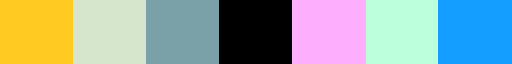

In [36]:
p.legend_dict[attributes[0]]['cmap']

In [37]:
p.legend_dict[attributes[0]]['values']

['sable', 'argile', 'marne', 'charbon', 'dolomie', 'schiste', 'calcaire']

## Display one object (attribute = 'lithology')

In [38]:
bh = 6
p.boreholes_3d[bh].components

{0: [Component({'lithology': 'sable'}),
  Component({'arsenic': 'vr'}),
  Component({'cadmium': 'vi'})],
 1: [Component({'lithology': 'argile'}),
  Component({'arsenic': 'inconnu'}),
  Component({'cadmium': 'vr'})],
 2: [Component({'lithology': 'marne'}),
  Component({'arsenic': 'inconnu'}),
  Component({'cadmium': 'inconnu'})],
 3: [Component({'lithology': 'charbon'}),
  Component({'arsenic': 'inconnu'}),
  Component({'cadmium': 'vs'})],
 4: [Component({'lithology': 'dolomie'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'inconnu'})],
 5: [Component({'lithology': 'calcaire'}),
  Component({'arsenic': 'vs'}),
  Component({'cadmium': 'vr'})]}

/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

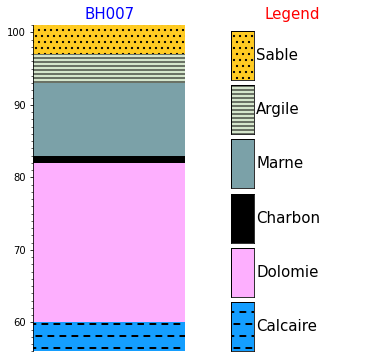

In [39]:
p.boreholes_3d[bh].log_plot()

In [40]:
sargs = dict(title='Test_legend', title_font_size=30, label_font_size=12, n_labels=0,
             fmt="%.2f", font_family="arial", color='k',interactive=True, 
             vertical=True, italic=True, shadow=False,)

In [41]:
p.boreholes_3d[bh].plot3d(custom_legend=False, scalar_bar_args=sargs)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [42]:
p.plot2d()

## Plot with another attribute

/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/Projects/GSDMA/utils/visual.py:421: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin, w, thick, fc=fc, lw=lw, hatch=d.hatch,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'=". Passing invalid values is deprecated since 3

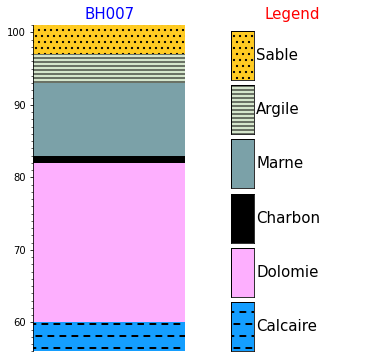

In [43]:
at = 0
p.boreholes_3d[bh].log_plot(repr_attribute=attributes[at])

In [44]:
p.boreholes_3d[bh].plot3d(repr_attribute=attributes[at])

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [45]:
p.boreholes_orm[0].intervals_values

2021-07-23 21:33:29,115 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id", "Intervals".data_id AS "Intervals_data_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-07-23 21:33:29,117 INFO sqlalchemy.engine.Engine [cached since 1.905s ago] ('BH001',)


{0: '{"lithology": "sable"}, {"arsenic": "vr"}, {"cadmium": "vr"}', 1: '{"lithology": "argile"}, {"arsenic": "vi"}, {"cadmium": "vs"}', 2: '{"lithology": "marne"}, {"arsenic": "vi"}, {"cadmium": "vi"}', 3: '{"lithology": "charbon"}, {"arsenic": "vi"}, {"cadmium": "vr"}'}

In [46]:
p.boreholes_3d[bh].intervals[0]

Interval({'top': Position({'middle': 101.0, 'x': 152794.0, 'y': 121111.0, 'units': 'm'}), 'base': Position({'middle': 97.0, 'x': 152794.0, 'y': 121111.0, 'units': 'm'}), 'description': '{"lithology": "sable"}, {"arsenic": "vr"}, {"cadmium": "vi"}', 'data': {}, 'components': [Component({'lithology': 'sable'}), Component({'arsenic': 'vr'}), Component({'cadmium': 'vi'})]})

### Display project boreholes

In [47]:
bh3d_vtk = p.boreholes_3d[bh]._vtk
bh3d_vtk

PolyData (0x7faa6b33d640)
  N Cells:	312
  N Points:	1200
  X Bounds:	1.528e+05, 1.528e+05
  Y Bounds:	1.211e+05, 1.211e+05
  Z Bounds:	5.600e+01, 1.010e+02
  N Arrays:	6

In [48]:
at = 0
p.plot3d(repr_attribute=attributes[at],  bg_color=["royalblue", "aliceblue"], 
                      window_size=(800, 500))

4 ['sable', 'argile', 'marne', 'charbon']
5 ['sable', 'argile', 'marne', 'charbon', 'dolomie']
5 ['sable', 'argile', 'marne', 'charbon', 'dolomie']
5 ['sable', 'argile', 'marne', 'charbon', 'dolomie']
7 ['sable', 'argile', 'marne', 'charbon', 'dolomie', 'schiste', 'calcaire']
5 ['sable', 'argile', 'marne', 'charbon', 'dolomie']
6 ['sable', 'argile', 'marne', 'charbon', 'dolomie', 'calcaire']
5 ['sable', 'argile', 'marne', 'charbon', 'dolomie']
5 ['sable', 'argile', 'marne', 'charbon', 'dolomie']
3 ['sable', 'argile', 'marne']
['sable', 'argile', 'marne', 'charbon', 'dolomie', 'schiste', 'calcaire']


2021-07-23 21:33:29.240 (   3.061s) [        AC866740]vtkDataSetAttributes.cx:1296  WARN| vtkPointData (0x5098b80): Can not set attribute Scalars. Only vtkDataArray subclasses can be set as active attributes.


### Boreholes in 3D using X3D for interaction within the notebook